<a href="https://colab.research.google.com/github/jyryu3161/bio_system_design/blob/main/Lab20_omics_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Omics integration

In [1]:
!git clone https://github.com/jyryu3161/bio_system_design.git

fatal: destination path 'bio_system_design' already exists and is not an empty directory.


In [12]:
!pip install cobra
!pip install pyparsing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 34.4 MB/s eta 0:00:00


# 발현 데이터 로딩

In [12]:
import pandas as pd

df = pd.read_csv('./bio_system_design/sample_expression.csv', index_col=0)
df

,GSM997604,GSM997618,GSM997606
8813,11.386154,11.333412,10.221427
2519,6.745405,6.318156,6.834729
2729,7.864433,8.351692,5.596138
51056,10.412596,8.199678,8.307508
9957,5.774470,6.348733,3.204646
...,...,...,...
11254,2.951388,3.041097,3.044244
8396,7.335139,7.217915,7.613758
284098,5.323485,5.283461,4.856555
6716,4.643121,4.933872,4.772665


# 발현 데이터를 Rank 기반 값으로 변경

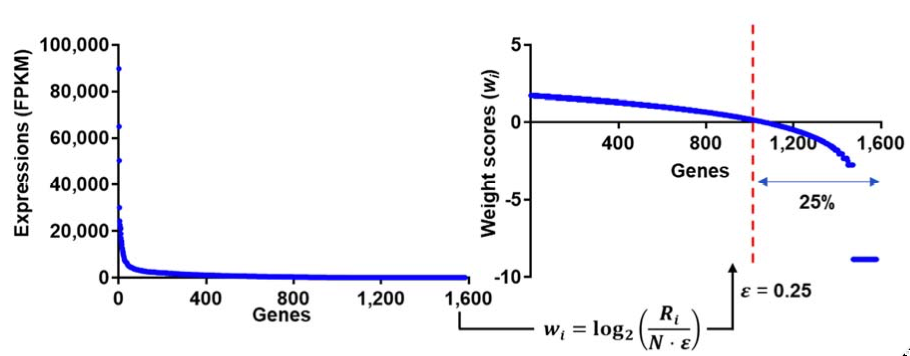

In [13]:
import numpy as np
import pandas as pd

def rank_based_expression_score(df_col: pd.DataFrame, threshold: float = 0.25) -> pd.Series:
    """
    df_col: single-column DataFrame (genes as index, expression as values)
    returns: log2-scaled rank-based score (Series)
    """
    s = df_col.squeeze()  # DataFrame(1-col) -> Series
    ranks = s.rank()

    score = np.log2(ranks / (ranks.max() * threshold))
    score.index = score.index.astype(str)
    return score


# example usage (첫 컬럼만)
col = df.columns[0]
score = rank_based_expression_score(df[[col]])
rank_score_df = score.to_frame(name=col)
print(rank_score_df)
rank_score_df.to_csv('./exp_rank.csv')



        GSM997604
8813     1.943947
2519     1.007563
2729     1.406958
51056    1.861833
9957     0.515710
...           ...
11254   -4.401828
8396     1.225909
284098   0.242029
6716    -0.442470
31       1.176440

[1522 rows x 1 columns]


# GPR calculation

In [29]:
import pyparsing
from cobra.io import read_sbml_model

import warnings
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

# cobra.io.sbml에서 나오는 Warning만 무시
warnings.filterwarnings(
    "ignore",
    category=Warning,
    module=r"cobra\.io\.sbml"
)

def convert_string_GPR_to_list_GPR(GPR_association):
    num = pyparsing.Word(pyparsing.alphanums)

    booleanop = pyparsing.oneOf('AND and OR or')
    expr = pyparsing.infixNotation(num,
                                   [(booleanop, 2, pyparsing.opAssoc.LEFT)])
    return expr.parseString(GPR_association)[0].asList()

cobra_model = read_sbml_model('./bio_system_design/Recon2M.2_Entrez_Gene_BIGG.xml')
print(len(cobra_model.reactions))

gpr = "(1 and 2) or 3"
gpr_list = convert_string_GPR_to_list_GPR(gpr)
print(gpr_list)

gpr = "1 and (2 or 3)"
gpr_list = convert_string_GPR_to_list_GPR(gpr)
print(gpr_list)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


6474
[['1', 'and', '2'], 'or', '3']
['1', 'and', ['2', 'or', '3']]


In [32]:
import numpy as np
import ast

def convert_gene_id_to_score(ls, expression_score_info_dic):
    for each_item in ls:
        if type(each_item) == list:
            return convert_gene_id_to_score(each_item, expression_score_info_dic)

    scores = []
    boolean_operations = []
    for i in range(len(ls)):
        each_item = ls[i]
        if each_item not in ['AND', 'and', 'OR', 'or']: # 가독성을 위해 변경
            if str(each_item) in expression_score_info_dic: # 키가 문자열이므로 str 변환 안전장치
                expression_value = expression_score_info_dic[str(each_item)]
                scores.append(expression_value)
            else:
                if isinstance(each_item, (int, float, np.number)):
                    expression_value = float(each_item)
                    scores.append(expression_value)
        else:
            boolean_operations.append(each_item)

    if scores == []:
        return ls, 0.0

    boolean_operations = list(set(boolean_operations))
    if len(boolean_operations) == 1:
        if boolean_operations[0] in ['AND', 'and']:
            return ls, np.min(scores)
        elif boolean_operations[0] in ['OR', 'or']:
            return ls, np.max(scores)
    else:
        return ls, np.max(scores)

def GPR_score_calculation(GPR_list, expression_score_info_dic):
    final_score = 0.0
    while True:
        GPR_string = str(GPR_list)
        converted_list, score = convert_gene_id_to_score(GPR_list, expression_score_info_dic)
        converted_list_string = str(converted_list)
        new_GPR_string = GPR_string.replace(converted_list_string, str(score))
        new_GPR_list = ast.literal_eval(new_GPR_string)
        GPR_list = new_GPR_list
        if type(GPR_list) != list:
            final_score = GPR_list
            break
    return final_score


gpr = "(1 and 2) or 3"

expression_score_info_dic = {}
expression_score_info_dic['1'] = 10
expression_score_info_dic['2'] = 50
expression_score_info_dic['3'] = 30

gpt_list = convert_string_GPR_to_list_GPR(gpr)
score = GPR_score_calculation(gpt_list, expression_score_info_dic)

print(gpt_list)
print(score)


gpr = "1 and (2 or 3)"

expression_score_info_dic = {}
expression_score_info_dic['1'] = 10
expression_score_info_dic['2'] = 50
expression_score_info_dic['3'] = 30

gpt_list = convert_string_GPR_to_list_GPR(gpr)
score = GPR_score_calculation(gpt_list, expression_score_info_dic)

print(gpt_list)
print(score)

[['1', 'and', '2'], 'or', '3']
30.0
['1', 'and', ['2', 'or', '3']]
10.0


In [28]:


def reaction_score_calculation(cobra_model, expression_score):
    expression_socre_string = {}
    for gene_id in expression_score:
        expression_socre_string[str(gene_id)] = expression_score[gene_id]

    reaction_weights = {}
    for each_reaction in cobra_model.reactions:
        reaction_weights[each_reaction.id] = 0.0
        GPR_association = each_reaction.gene_reaction_rule
        genes = [str(gene.id) for gene in each_reaction.genes]

        genes = list(set(genes) & set(expression_socre_string.keys()))

        if len(genes) > 1:
            GPR_list = convert_string_GPR_to_list_GPR(GPR_association)
            expression = GPR_score_calculation(GPR_list, expression_socre_string)
            reaction_weights[each_reaction.id] = expression
        elif len(genes) == 1:
            gene_id = genes[0].strip()
            if gene_id in expression_socre_string:
                expression = expression_socre_string[gene_id]
                reaction_weights[each_reaction.id] = expression
    return reaction_weights


col = rank_score_df.columns[0]
expression_score = rank_score_df[col].to_dict()

reaction_weights = reaction_score_calculation(cobra_model, expression_score)
print(reaction_weights)
for each_reaction in reaction_weights:
    if abs(reaction_weights[each_reaction]) > 0:
        print(each_reaction, reaction_weights[each_reaction])


{'EX_cpppg1_e_boundary': 0.0, 'EX_wharachd_e_boundary': 0.0, 'EX_ddca_e_boundary': 0.0, 'EX_ttdcrn_e_boundary': 0.0, 'EX_nad_m_boundary': 0.0, 'EX_fad_m_boundary': 0.0, 'EX_13_cis_oretn_n_boundary': 0.0, 'EX_13_cis_retn_n_boundary': 0.0, 'EX_1a25dhvitd3_n_boundary': 0.0, 'EX_4abut_n_boundary': 0.0, 'EX_4hpro_LT_m_boundary': 0.0, 'EX_5HPET_r_boundary': 0.0, 'EX_anth_c_boundary': 0.0, 'EX_Asn_X_Ser_Thr_l_boundary': 0.0, 'EX_avite1_c_boundary': 0.0, 'EX_btn_c_boundary': 0.0, 'EX_core5_g_boundary': 0.0, 'EX_core7_g_boundary': 0.0, 'EX_core8_g_boundary': 0.0, 'EX_datp_m_boundary': 0.0, 'EX_datp_n_boundary': 0.0, 'EX_dctp_m_boundary': 0.0, 'EX_dctp_n_boundary': 0.0, 'EX_dem2emgacpail_prot_hs_r_boundary': 0.0, 'EX_dgpi_prot_hs_r_boundary': 0.0, 'EX_dgtp_m_boundary': 0.0, 'EX_dgtp_n_boundary': 0.0, 'EX_dsT_antigen_g_boundary': 0.0, 'EX_dttp_m_boundary': 0.0, 'EX_dttp_n_boundary': 0.0, 'EX_ethamp_r_boundary': 0.0, 'EX_fol_c_boundary': 0.0, 'EX_gncore2_g_boundary': 0.0, 'EX_gpi_sig_r_boundary': 

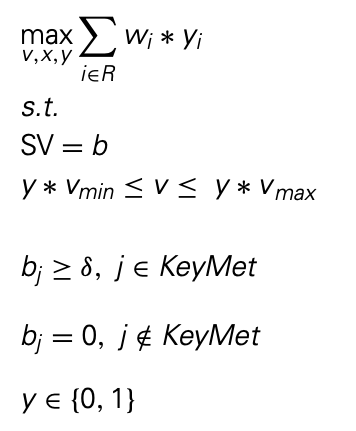